# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
import os
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np

In [4]:
### TODO: Write data loaders for training, validation, and test sets

# Get paths to the files 
gen_dir = '/data/landmark_images/'
train_dir = os.path.join(gen_dir, 'train')
test_dir = os.path.join(gen_dir, 'test')

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


In [5]:
loaders_scratch

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff4eaa36e80>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7ff4eaa367f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ff53c033550>}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I resized and cropped the images to 224 pixels because it is the general rule of thumb for large scale CNN networks. Then I transform the image into a tensor and I normalized it. The input size of the tensor is (3x224x224) (i.e. what is also used by ImageNet)
- For the first iteration I have decided not to augment the dataset to test if I can achieve the required accuracy. If that's not the case I will come back to experiment with various flips, rotations etc
 - 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

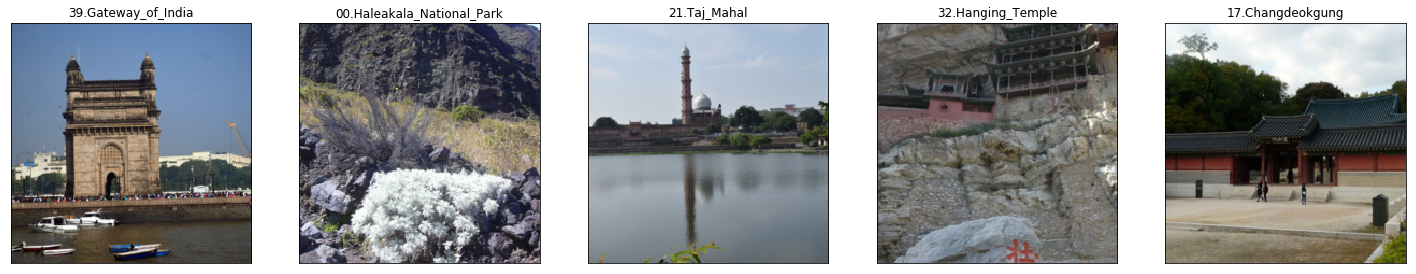

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes = train_data.classes
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 16))
# display 20 images
for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [7]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [8]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [22]:
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 104891218.67it/s]


In [27]:
VGG16.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [9]:
import torch.nn as nn
import torch.nn.functional as F

N_CLASSES = len(classes) # 50 landmarks in the dataset

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        
        self.fc1 = nn.Linear(512 * 14 * 14, 256*4)
        self.fc2 = nn.Linear(256*4, N_CLASSES) 
        self.dropout = nn.Dropout(0.25) # Select a dropout ratio

    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        # Move from convolutional to linear layers
        x = x.view(x.size(0), -1) #x.flatten()
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x) 
        
        return x
        
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

**Answer:** Although we haven't reached the step of transfer learning, I didn't want to start of scratch so I pulled the architecture of the VGG16 network to examine its main components. So I followed a similar logic. I applied 4 convolutional layers. The first increased the depth from 3 to 64 and each of the following ones increased the depth by a factor of 2. I also went with the most popular kernel size (3x3) and with a stride and padding of 1. Inbetween the convolutional layers, a 2x2 MaxPool layer was reducing in half the other dimensions, in order to focus on the important targets. A RELU function was applied at every convolutional layer. Finally, after a flattened the output, I used two linear layers in the fully connected component. The final layer had as output the number of classes that was extracted from the training set. Also, I used a dropout of 0.25 to avoid overfitting.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

In [15]:
model_scratch.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [74]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
    # m.weight.data shoud be taken from a normal distribution
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0,y)
    # m.bias.data should be 0
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.127572 	Validation Loss: 0.780116
Validation loss decreased (inf --> 0.780116).  Saving model ...
Epoch: 2 	Training Loss: 3.091825 	Validation Loss: 0.758035
Validation loss decreased (0.780116 --> 0.758035).  Saving model ...
Epoch: 3 	Training Loss: 2.936325 	Validation Loss: 0.703023
Validation loss decreased (0.758035 --> 0.703023).  Saving model ...
Epoch: 4 	Training Loss: 2.755497 	Validation Loss: 0.679537
Validation loss decreased (0.703023 --> 0.679537).  Saving model ...
Epoch: 5 	Training Loss: 2.633120 	Validation Loss: 0.681482
Epoch: 6 	Training Loss: 2.529635 	Validation Loss: 0.655981
Validation loss decreased (0.679537 --> 0.655981).  Saving model ...
Epoch: 7 	Training Loss: 2.383322 	Validation Loss: 0.642923
Validation loss decreased (0.655981 --> 0.642923).  Saving model ...
Epoch: 8 	Training Loss: 2.270260 	Validation Loss: 0.630629
Validation loss decreased (0.642923 --> 0.630629).  Saving model ...
Epoch: 9 	Training Loss: 2.083808 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.129569 	Validation Loss: 0.781484
Validation loss decreased (inf --> 0.781484).  Saving model ...
Epoch: 2 	Training Loss: 3.123132 	Validation Loss: 0.778537
Validation loss decreased (0.781484 --> 0.778537).  Saving model ...
Epoch: 3 	Training Loss: 3.083047 	Validation Loss: 0.748660
Validation loss decreased (0.778537 --> 0.748660).  Saving model ...
Epoch: 4 	Training Loss: 2.963552 	Validation Loss: 0.733610
Validation loss decreased (0.748660 --> 0.733610).  Saving model ...
Epoch: 5 	Training Loss: 2.875533 	Validation Loss: 0.713419
Validation loss decreased (0.733610 --> 0.713419).  Saving model ...
Epoch: 6 	Training Loss: 2.802705 	Validation Loss: 0.705895
Validation loss decreased (0.713419 --> 0.705895).  Saving model ...
Epoch: 7 	Training Loss: 2.718821 	Validation Loss: 0.687888
Validation loss decreased (0.705895 --> 0.687888).  Saving model ...
Epoch: 8 	Training Loss: 2.580701 	Validation Loss: 0.676822
Validation loss decreased (0.68788

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_landmark.pt')) # Forgot to add save path in the train function so it was saved in the predefined namepath. Left it like that to avoid gpu retraining
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.099162


Test Accuracy: 22% (278/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
### TODO: Write data loaders for training, validation, and test sets

# Get paths to the files 
gen_dir = '/data/landmark_images/'
train_dir = os.path.join(gen_dir, 'train')
test_dir = os.path.join(gen_dir, 'test')

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [19]:
loaders_transfer

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff4e43c1f60>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7ff4e43c1f98>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ff4e43c1eb8>}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [26]:
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    # specify optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
    
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [23]:
print(VGG16.classifier[6].in_features) 
print(VGG16.classifier[6].out_features) 

4096
1000


In [24]:
## TODO: Specify model architecture
# Freeze training for all "features" layers
for param in VGG16.features.parameters():
    param.requires_grad = False
    
n_inputs = VGG16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
VGG16.classifier[6] = last_layer

model_transfer = VGG16

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

50


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  The steps that were followed are the following: a) VGG-16 was selected for transfer learning. This way we keep a similar (but deeper) architecture compared with the one that was used for the previous model. Also VGG-16 is trained with millions images and used in several image processing applications. b) I am freezing the parameters of the feature layers of the model so that we only train the classifier and c) I am replacing the the last layer of the classifier so that it corresponds to the number of classes of our problem

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# number of epochs to train the model
n_epochs = 20

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.837809 	Validation Loss: 0.277688
Validation loss decreased (inf --> 0.277688).  Saving model ...
Epoch: 2 	Training Loss: 0.951877 	Validation Loss: 0.240497
Validation loss decreased (0.277688 --> 0.240497).  Saving model ...
Epoch: 3 	Training Loss: 0.662849 	Validation Loss: 0.224473
Validation loss decreased (0.240497 --> 0.224473).  Saving model ...
Epoch: 4 	Training Loss: 0.491800 	Validation Loss: 0.215531
Validation loss decreased (0.224473 --> 0.215531).  Saving model ...
Epoch: 5 	Training Loss: 0.360542 	Validation Loss: 0.212707
Validation loss decreased (0.215531 --> 0.212707).  Saving model ...
Epoch: 6 	Training Loss: 0.249429 	Validation Loss: 0.214069
Epoch: 7 	Training Loss: 0.184555 	Validation Loss: 0.219898
Epoch: 8 	Training Loss: 0.141658 	Validation Loss: 0.221377
Epoch: 9 	Training Loss: 0.109067 	Validation Loss: 0.225509
Epoch: 10 	Training Loss: 0.084350 	Validation Loss: 0.231350
Epoch: 11 	Training Loss: 0.068033 	Validation Lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [28]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.897967


Test Accuracy: 76% (951/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [44]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    image= transform(image)
    image.unsqueeze_(0)
    
    if use_cuda:
        image = image.cuda()
        
    model_transfer.eval()
    
    pred = model_transfer(image)
    values, indices = pred.topk(k)
    
    top_k_landmarks = []
    
    for i in indices[0].tolist():
        top_k_landmarks.append(classes[i].split(".",1)[1].replace('_',' '))
        
    return top_k_landmarks


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

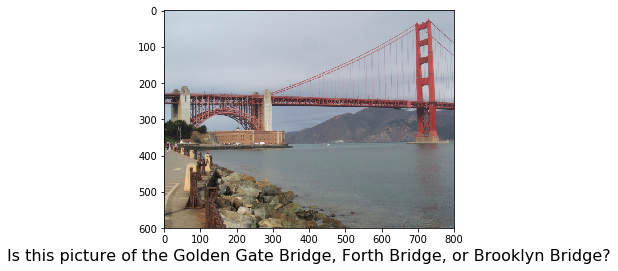

In [46]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path)
    
    fig = plt.figure(figsize=(25, 4))
    #ax = fig.add_subplot(2, 20, 1, xticks=[], yticks=[])
    plt.imshow(image)
    plt.xlabel('Is this picture of the {}, {}, or {}?'.format(predicted_landmarks[0],predicted_landmarks[1],predicted_landmarks[2]),fontsize=16)

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

*Answer:* From the 4 images that I uploaded it predicts correctly the three while it gets relatively close to the fourth (this is in line with the 76% accuracy that we found earlier so it's exactly as expected) 
Three points for improvement: 
- Image augmentation: By adding random noise to our training images we could possibly take into account flipped or strangely positioned pictures 
- Identifying the weak points of the prediction and add more related landmarks to the training dataset 
- Experiment with other pre-trained model architectures 

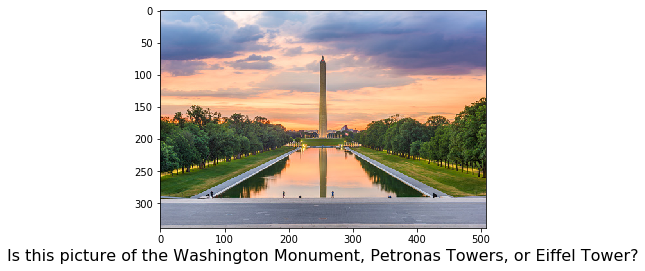

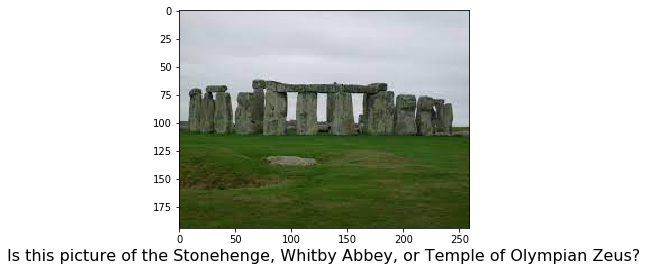

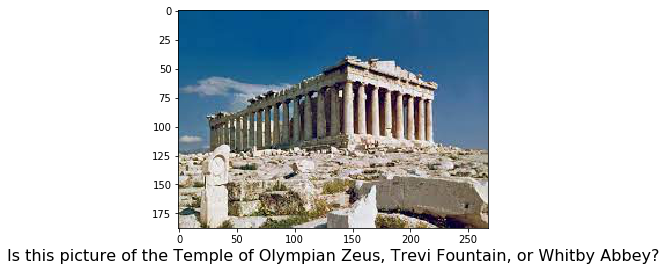

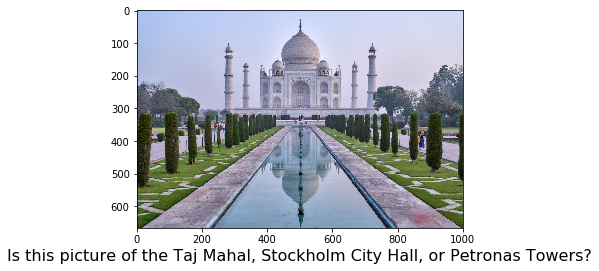

In [69]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
for filename in os.listdir("images/mytest/"):
    suggest_locations("images/mytest/"+filename)